In [9]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d, binned_statistic
from numba import njit
from astropy.io import fits

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/GSEgas/'

import sys
sys.path.append(basepath+'note/')
import galaxy

from scipy.ndimage import gaussian_filter

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
GFM_SOLAR_ABUNDANCE_HYDROGEN = 0.7388

GFM_SOLAR_ABUNDANCE_MAGNESIUM = 0.0007
GFM_SOLAR_ABUNDANCE_IRON   =   0.0013

In [4]:
sim0 = ('142', '116', '04')
sim1 = ('129', '116', '04')

In [5]:
def load_galaxy(sim, idx=320):
    Rs, Vv, ecc = sim
    key = 'lvl4-Rs'+Rs+'-Vv'+Vv+'-e'+ecc
    return galaxy.Galaxy(basepath + 'runs/MW7_GSE4-eRVgrid-lvl4/' + key + '/output',
                                              idx, orient=True)

In [23]:
gal0 = load_galaxy(sim0)
gal1 = load_galaxy(sim1)
galiso = galaxy.Galaxy(basepath + 'runs/MW7iso/lvl4-Ngb64/output', 320, orient=True)

In [24]:
def extract_sim_data(gal):
    sn = gal.sn
    
    ### get logFeH and logMgFe ###
    FeH = sn.part4.GFM_Metals[:,8] / GFM_SOLAR_ABUNDANCE_IRON
    MgH = sn.part4.GFM_Metals[:,6] / GFM_SOLAR_ABUNDANCE_MAGNESIUM
    
    logFeH = np.log10(FeH)
    logMgH = np.log10(MgH)
    logMgFe = logMgH - logFeH

    ### get in_SN ###
    Lzsun = 8 * 220 * 0.2
    zmax = 3
    dLz = 0.3
    
    Lz = np.cross(sn.part4.rotpos, sn.part4.rotvel)[:,2]
    in_SN = np.logical_and(np.abs((Lz/Lzsun)-1) < dLz, np.abs(sn.part4.rotpos[:,2]) < zmax)
    
    ### get tform ###
    tform = sn.part4.GFM_StellarFormationTime
    keybool = np.logical_and(in_SN, tform > 0)
    
    out = {}
    out['logFeH'] = logFeH[in_SN]
    out['logMgFe'] = logMgFe[in_SN]
    out['tform'] = tform[in_SN]
    
    return out

simdata0 = extract_sim_data(gal0)
simdata1 = extract_sim_data(gal1)
simdataiso = extract_sim_data(galiso)

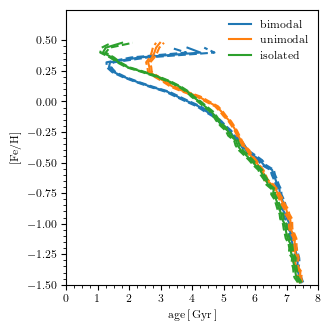

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(columnwidth, columnwidth))

logFeH_bins = np.linspace(-1.5, 0.5, 50+1)
logFeH_cen = 0.5 * (logFeH_bins[1:] + logFeH_bins[:-1])

labels = [r'$\textrm{bimodal}$', r'$\textrm{unimodal}$', r'$\textrm{isolated}$']

for data,label in zip([simdata0, simdata1, simdataiso], labels):
    logFeH = data['logFeH']
    tform = data['tform']

    age = 8 - tform
    
    age_mean, _, _ = binned_statistic(logFeH, age, bins=logFeH_bins)
    age_std, _, _ = binned_statistic(logFeH, age, statistic='std', bins=logFeH_bins)
    age_ct, _, _ = binned_statistic(logFeH, age, statistic='count', bins=logFeH_bins)
    
    age_se = age_std/np.sqrt(age_ct)
    
    l = ax.plot(age_mean, logFeH_cen, label=label)
    ax.plot(age_mean+2*age_se, logFeH_cen, ls='dashed', c=l[0].get_color())
    ax.plot(age_mean-2*age_se, logFeH_cen, ls='dashed', c=l[0].get_color())
    

ax.set(xlim=(0, 8), ylim=(-1.5, 0.75))
ax.set(xlabel=r'$\textrm{age}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Fe}/\textrm{H}]$')
ax.set(xticks=np.arange(0, 8+1, 1), yticks=np.arange(-1.5, 0.5+0.25, 0.25))
ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
ax.set_yticks(np.arange(-1.5, 0.5+0.05, 0.05), minor=True)

ax.legend(frameon=False)
fig.tight_layout()
fig.savefig('AMR.pdf')

(1000.0, 50000.0)
(1000.0, 50000.0)
(1000.0, 50000.0)


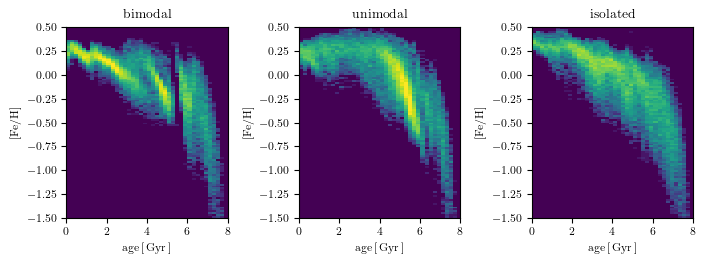

In [46]:
fig, axs = plt.subplots(1, 3, figsize=(textwidth, 0.8*columnwidth))

logFeH_bins = np.linspace(-1.5, 0.5, 100+1)

tform_bins = np.linspace(0, 8, 40+1)

labels = [r'$\textrm{bimodal}$', r'$\textrm{unimodal}$', r'$\textrm{isolated}$']
datas = [simdata0, simdata1, simdataiso]

vmin = 1e3
vmax = 5e4

for data,label,ax in zip(datas, labels, axs):
    logFeH = data['logFeH']
    tform = data['tform']

    dFeH = logFeH_bins[1] - logFeH_bins[0]
    dt = tform_bins[1] - tform_bins[0]
    
    H, _, _, _ = binned_statistic_2d(8-tform, logFeH, np.ones_like(logFeH)/dFeH/dt, 
                                  statistic='sum', bins=[tform_bins, logFeH_bins])

    extent = [tform_bins[0], tform_bins[-1], logFeH_bins[0], logFeH_bins[-1]]
    
    H[H < vmin] = vmin
    
    im = ax.imshow(H.T, origin='lower', interpolation='None',
                   extent=extent, norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax))
    
    ax.set(xlabel=r'$\textrm{age}\,[\,\textrm{Gyr}\,]$', ylabel=r'$[\textrm{Fe}/\textrm{H}]$')
    ax.set_aspect('auto')
    ax.set(title=label)
    
    print(im.get_clim())
    
    # ax.set(xticks=np.arange(0, 8+1, 1), yticks=np.arange(-1.5, 0.5+0.25, 0.25))
    # ax.set_xticks(np.arange(0, 8+0.25, 0.25), minor=True)
    # ax.set_yticks(np.arange(-1.5, 0.5+0.05, 0.05), minor=True)

fig.tight_layout()
fig.savefig('AMR_2D.pdf')